# International Tourism Analysis

## Setup

First we need to import the requisite libraries and our data.

In [ ]:
import pandas as pd
import sqlite3
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [3]:
sns.set_theme(context='notebook')
pio.renderers.default = "notebook"
pio.templates.default = 'seaborn'

In [4]:
connection = sqlite3.connect('./data/db/tourism.db')
cursor = connection.cursor()

In [5]:
query = '''
    SELECT
        a.country_code AS 'country_code',
        c.country AS 'country',
        c.region AS 'region',
        c.income_group AS 'income_group',
        AVG(p.population) AS 'avg_population',
        AVG(eb.earned_bachelors) AS 'avg_pct_earned_bachelors',
        AVG(a.arrivals) AS 'avg_arrivals',
        AVG(d.departures) AS 'avg_departures',
        AVG(gdp.gdp) AS 'avg_gdp',
        AVG(gpc.gdp_per_capita) AS 'avg_gdp_per_capita',
        AVG(i.income) AS 'avg_income',
        AVG(r.receipts) AS 'avg_receipts',
        AVG(e.expenditures) AS 'avg_expenditures'
    FROM arrivals a
    JOIN country c ON c.country_code = a.country_code
    JOIN departures d ON d.country_code = a.country_code AND d.'year' = a.'year'
    JOIN receipts r ON r.country_code = a.country_code AND r.'year' = a.'year'
    JOIN expenditures e ON e.country_code = a.country_code AND e.'year' = a.'year'
    JOIN gdp ON gdp.country_code = a.country_code AND gdp.'year' = a.'year'
    JOIN gdp_per_capita gpc ON gpc.country_code = a.country_code AND gpc.'year' = a.'year'
    JOIN income i ON i.country_code = a.country_code AND i.'year' = a.'year'
    JOIN population p ON p.country_code = a.country_code AND p.'year' = a.'year'
    JOIN earned_bachelors eb ON eb.country_code = a.country_code AND eb.'year' = a.'year'
    GROUP BY a.country_code;
    '''

df_country_avgs = pd.read_sql(query, connection)

df_country_avgs

country_code       country                      region  \
0            ABW         Aruba   Latin America & Caribbean   
1            AFG   Afghanistan                  South Asia   
2            AGO        Angola          Sub-Saharan Africa   
3            ALB       Albania       Europe & Central Asia   
4            AND       Andorra       Europe & Central Asia   
..           ...           ...                         ...   
212          XKX        Kosovo       Europe & Central Asia   
213          YEM   Yemen, Rep.  Middle East & North Africa   
214          ZAF  South Africa          Sub-Saharan Africa   
215          ZMB        Zambia          Sub-Saharan Africa   
216          ZWE      Zimbabwe          Sub-Saharan Africa   

            income_group  avg_population  avg_pct_earned_bachelors  \
0            High income    9.734629e+04                 14.609690   
1             Low income    2.752031e+07                       NaN   
2    Lower middle income    2.286350e+07                  2.315715   
3    Upper middle income    2.967187e+06                 11.659310   
4            High income    7.258258e+04                 19.154652   
..                   ...             ...                       ...   
212  Upper middle income    1.779319e+06                       NaN   
213           Low income    2.406690e+07                       NaN   
214  Upper middle income    5.144290e+07                  7.448600   
215  Lower middle income    1.341067e+07                  1.814720   
216  Lower middle income    1.302597e+07                  5.307000   

     avg_arrivals  avg_departures       avg_gdp  avg_gdp_per_capita  \
0    1.418087e+06             NaN  2.811697e+09        28878.362057   
1             NaN             NaN  1.554853e+10          507.160308   
2    2.686522e+05          3000.0  6.012234e+10         2549.271059   
3    2.251708e+06       3424800.0  9.300193e+09         3163.794155   
4    9.276318e+06             NaN  2.758861e+09        37864.195068   
..            ...             ...           ...                 ...   
212           NaN             NaN  6.059312e+09         3386.673055   
213  1.071833e+06             NaN  4.791237e+10         2015.595007   
214  9.857192e+06             NaN  2.919822e+11         5632.729076   
215  7.295833e+05             NaN  1.508186e+10         1080.888252   
216  2.038625e+06       1369500.0  1.750242e+10         1348.046444   

       avg_income  avg_receipts  avg_expenditures  
0    20589.775076  1.260650e+09      2.637500e+08  
1      512.874531  9.992308e+07      1.284615e+08  
2     1557.441983  4.263333e+08      3.660000e+08  
3     2806.613815  1.272042e+09      1.039792e+09  
4             NaN  1.910000e+09      1.870000e+08  
..            ...           ...               ...  
212           NaN           NaN               NaN  
213    693.072772  8.191429e+08      1.773684e+08  
214   4698.900301  7.617333e+09      4.985583e+09  
215    769.607507           NaN      2.358696e+08  
216    714.822884  1.783750e+08      2.998571e+08  

[217 rows x 13 columns]

## Exploration

Now that we have our initial set of data fully loaded, let's begin exploring the data see if there are any trends that immediately pop out.

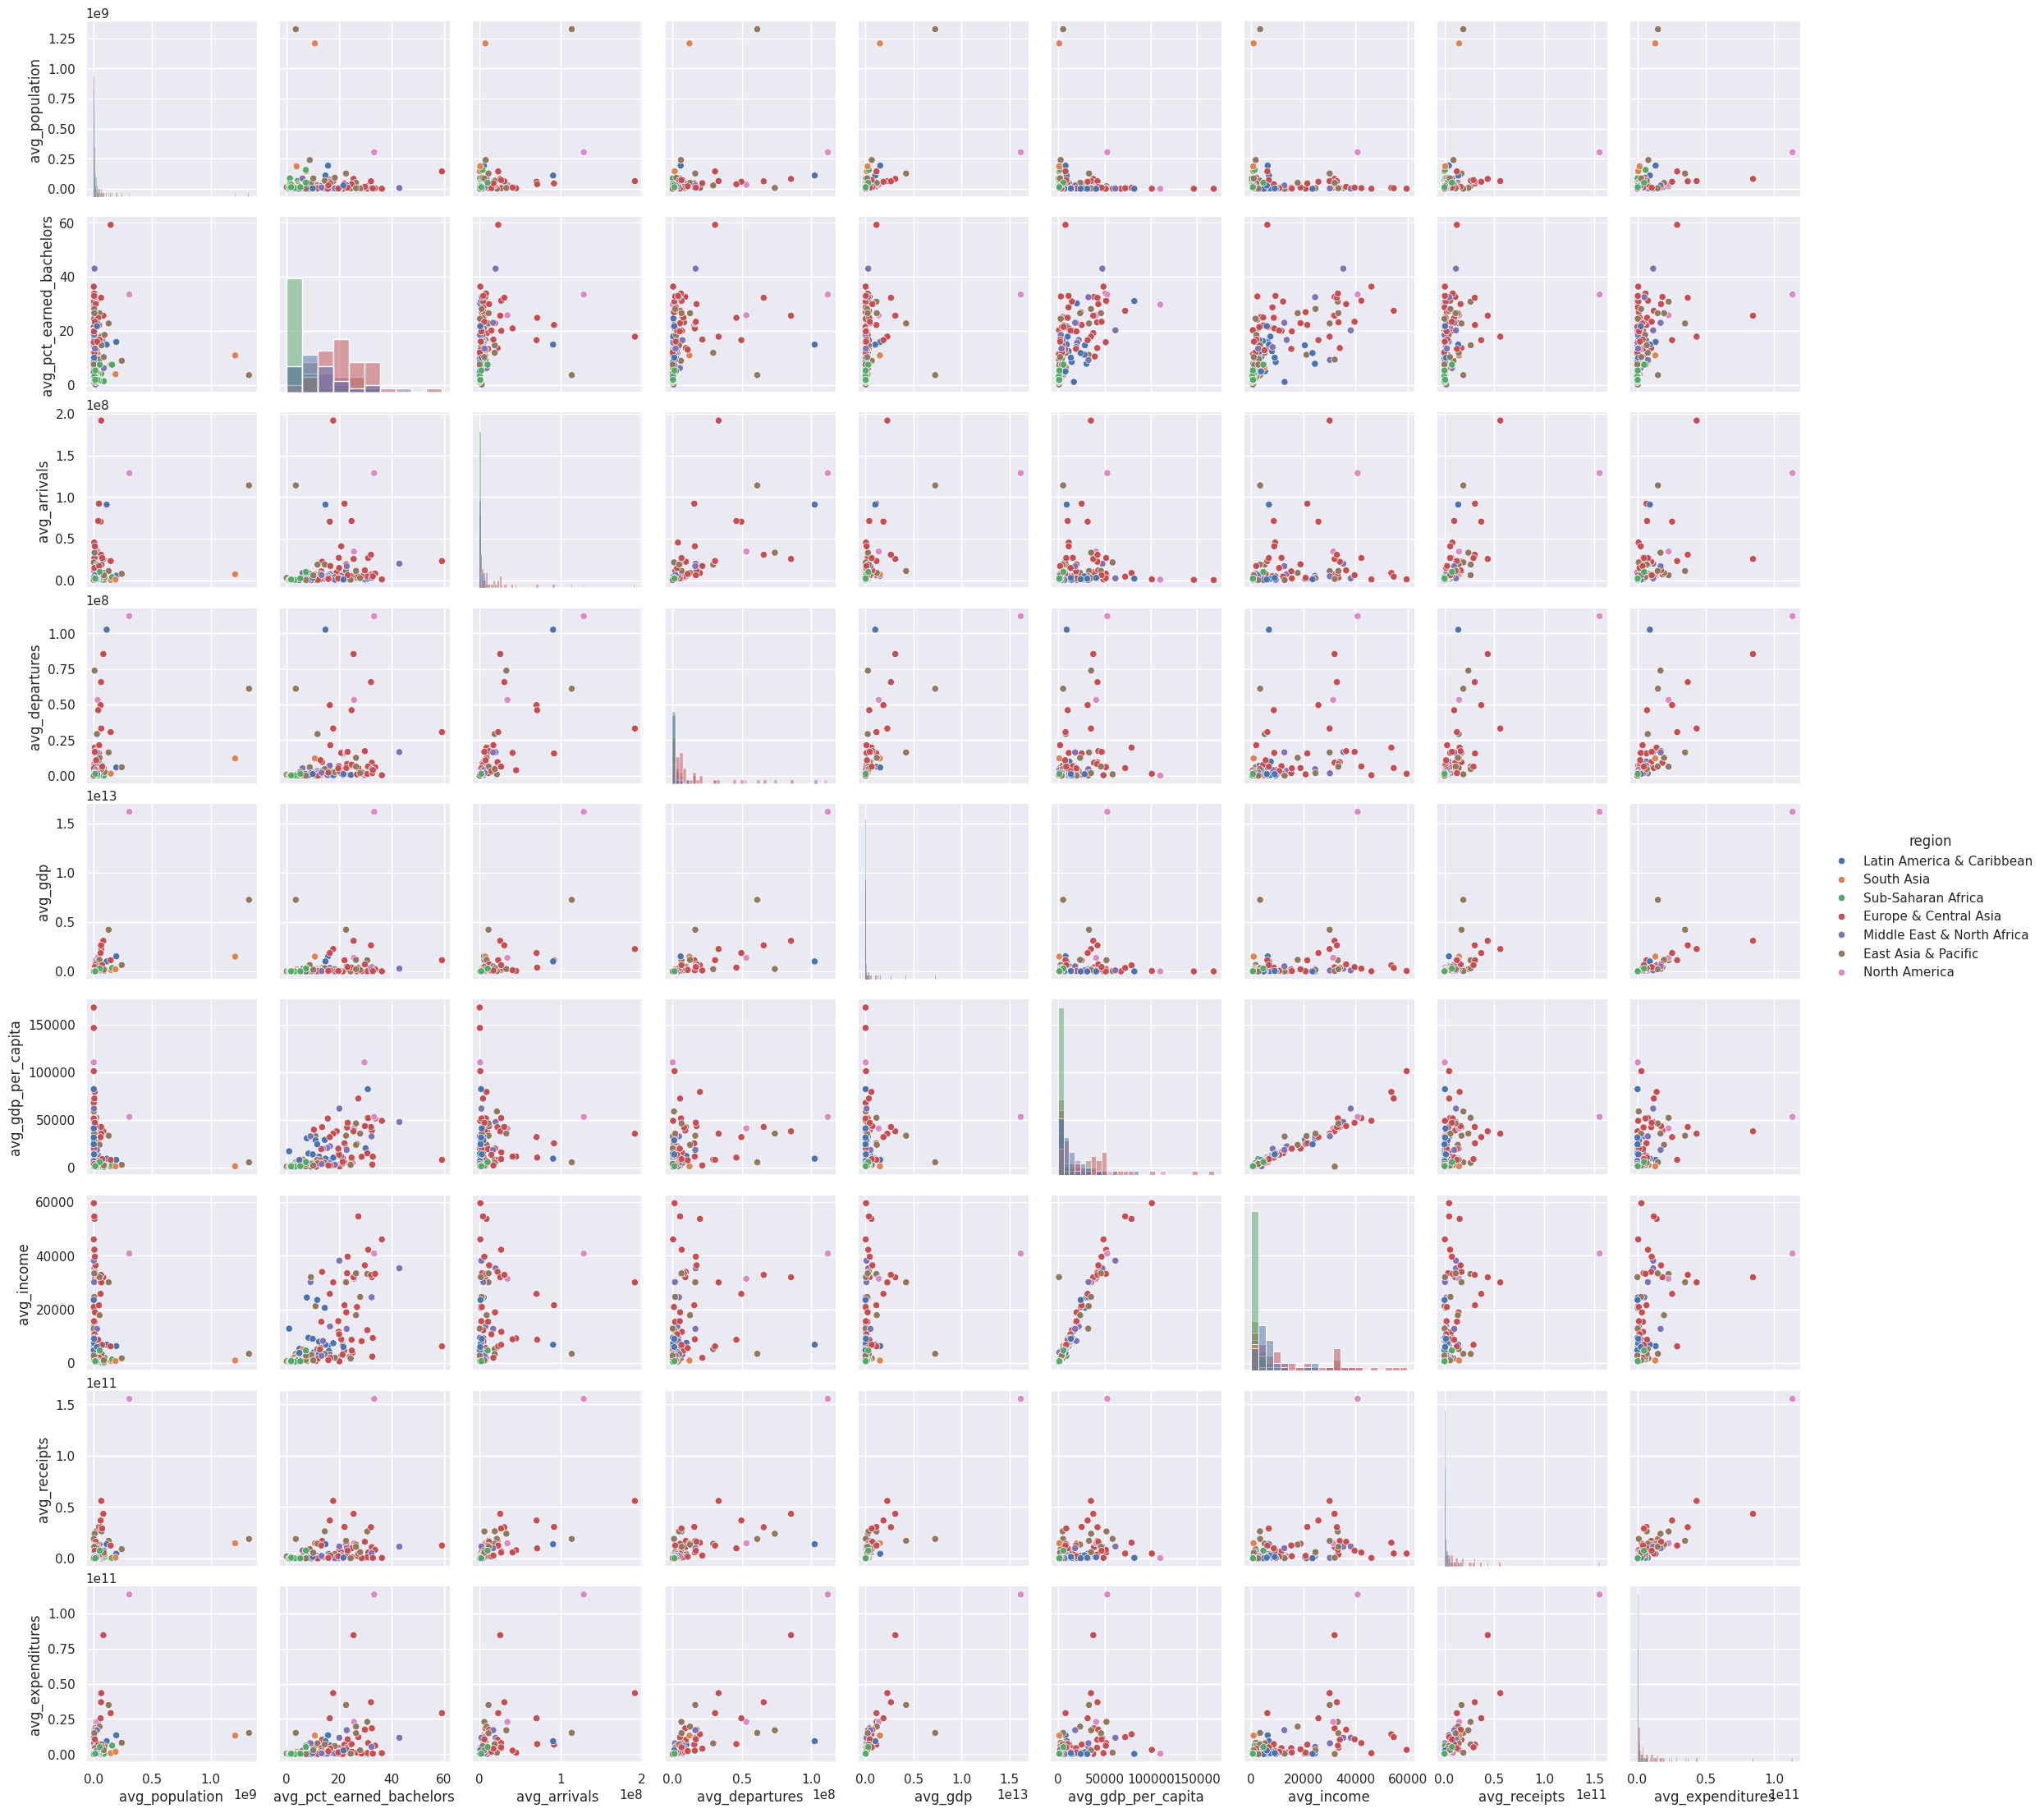

In [6]:
sns.pairplot(data=df_country_avgs, hue='region', diag_kind='hist', dropna=True)

plt.show()

There do not appear to be any obvious correlations based on these scatterplots except for ones that are unrelated to the scope of our analysis (eg, GDP and Income).

## Which countries are make up the most popular destinations?

Let's plot each of our metrics on a world map to see if we can find answers to some basic questions, such as "Which countries are the most popular destinations?" or "Which countries' citizens travel abroad the most?". 

We can start by making a couple of functions that will generate a map for each column passed into it.

In [7]:
def formatter(val, USD):
    """
    Takes a value and returns it formatted in a more legible way. 
    Args:
        value (val): the number to be formatted
        bool (USD): whether the number should be formatted with a $ at the beginning (True) or not (False)
    Returns:
        string (f_val): input value formatted as a legibile string.
    """
    val = float(val)
    abs_val = np.abs(val)
    f_val = ''
    
    if abs_val >= 10**12:
        f_val = f'{val/(10**12):.2f}T'
    elif abs_val >= 10**9:
        f_val = f'{val/(10**9):.2f}B'
    elif abs_val >= 10**6:
        f_val = f'{val/(10**6):.2f}M'
    elif abs_val >= 10**3:
        f_val = f'{val/(10**3):.2f}K'
    else:
        f_val = f'{val:.0f}'
    
    if USD:
        f_val = f'${f_val}'
    
    if val < 0:
        f_val = f'${f_val}'

    return f_val

In [8]:
def world_map_avgs(data_frame, column_name, plot_title, colorbar_title, typing, num_of_ticks):
    """
    Takes a column from a data frame and plots it on an interactive world choropleth map.
    Args:
        dataframe (pd.DataFrame()): the dataframe containing the column to be plotted.
        column_name (string): the name of the column to be plotted, formatted as a string.
        plot_title (string): the title of the map.
        colorbar_title (string): the title of the colorbar
        typing (string): how the data should be displayed; options are 'number', 'USD' or 'percent'.
        num_ticks (int): the total number of ticks on the color bar.
    """
    df = data_frame
    plotted_column = df[column_name]
    column_max = plotted_column.max()
    column_min = plotted_column.min()

    hover_data = []

    ### Setting the map's parameters according to which way the data is to be formatted
    if typing == 'percent':
        z_data = plotted_column
        z_min=0
        z_max=101
        tick_step_val = 100 / (num_of_ticks - 1)
        tick_val_max = 100 + tick_step_val
        tick_vals = [n for n in np.arange(0, tick_val_max , tick_step_val)]
        tick_text = []
        for val in tick_vals:
            tick_text.append(f'{val:.0f}%')
        for val in plotted_column.to_list():
            hover_data.append(f'{val:.2f}%')
    else:
        z_data = np.log10(df[column_name])
        z_min = np.log10(int(column_min))
        z_max = np.log10(int(column_max))
        pre_tick_text = np.logspace(z_min, z_max, num=num_of_ticks)
        tick_vals = [np.log10(n) for n in pre_tick_text]
        tick_text = []
        for val in pre_tick_text:
            if typing == 'USD':
                tick_text.append(formatter(val, typing))
            else:
                tick_text.append(formatter(val, typing))
        if typing == 'USD':
            for val in plotted_column.to_list():
                hover_data.append(formatter(val, typing))
            else:
                hover_data.append(formatter(val, typing))
    
    ### Creating the choropleth map by inserting the variable parameters and data
    fig = go.Figure(data=go.Choropleth(
        locations=df.country_code,
        z=z_data,
        zauto=False,
        zmin=z_min,
        zmax=z_max,
        text=df.country,
        colorscale='plasma',
        autocolorscale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar_title=f'{colorbar_title}<br>',
        colorbar={
            'tickvals': tick_vals,
            'ticktext': tick_text
        },
        customdata=hover_data,
        hovertemplate='%{text}: %{customdata}', 
        name=''
        )
    )

    fig.update_layout(
        width=1024,
        height=512,
        title_text=f'Average {plot_title}<br>(1995-2020)',
        geo={
            'showframe': True,
            'showcoastlines': False,
            'projection_type': 'natural earth'
        }
    )
    
    ### Displaying the graph
    fig.show()

And then pass our data through to it!

In [10]:
plot_titles = {
    'avg_population': 'population',
    'avg_arrivals': 'annual international tourist arrivals',
    'avg_departures': 'annual international departures abroad',
    'avg_gdp': 'annual GDP',
    'avg_gdp_per_capita': 'annual GDP per capita',
    'avg_income': 'annual income per capita',
    'avg_expenditures': 'annual expenditures abroad',
    'avg_receipts': 'annual receipts from<br>international tourism',
    'avg_pct_earned_bachelors': 'percentage of<br>population with bachelors degree'
}

colorbar_titles = {
    'avg_population': 'Population',
    'avg_arrivals': 'Arrivals',
    'avg_departures': 'Departures',
    'avg_gdp': 'GDP (USD)',
    'avg_gdp_per_capita': 'GDP per<br>capita (USD)',
    'avg_income': 'Income per<br>capita (USD)',
    'avg_expenditures': 'Expenditures<br>abroad',
    'avg_receipts': 'Receipts (USD)',
    'avg_pct_earned_bachelors': 'Percentage of<br>population with<br>bachelors degree'
}

types = {
    'avg_arrivals': 'number',
    'avg_departures': 'number',
    'avg_population': 'number',
    'avg_gdp': 'USD',
    'avg_gdp_per_capita': 'USD',
    'avg_income': 'USD',
    'avg_expenditures': 'USD',
    'avg_receipts': 'USD',
    'avg_pct_earned_bachelors': 'percent'
}

df_country_avgs = df_country_avgs[['country_code', 'country', 'region', 'income_group', 'avg_arrivals', 'avg_departures',
                                    'avg_receipts', 'avg_expenditures','avg_population', 'avg_gdp', 'avg_gdp_per_capita',
                                    'avg_income', 'avg_pct_earned_bachelors']]

for column in df_country_avgs.columns.tolist():
    if column not in ['country_code', 'country', 'region', 'income_group']:
        world_map_avgs(df_country_avgs, column, plot_titles[column], colorbar_titles[column], types[column], 4)

By looking at these maps, we can see that they are all ver

## Which Countries are the most economically dependent on tourism?

Out of all of the world's countries, which depend most on tourism? A simple way to tell by using the data is by finding the ratio as a percentage between a country's receipts from international tourism to its Gross Domestic Product (GDP). The higher the percentage, the more that country's economy depends on tourism to survive.

Let's begin by find that ratio and adding it to our dataframe.

In [ ]:
rgdp = 'receipts_to_gdp_ratio'
df_country_avgs[rgdp] = df_country_avgs.avg_receipts / df_country_avgs.avg_gdp

Now let's get an idea of how the data is distributed by plotting it on a histogram.

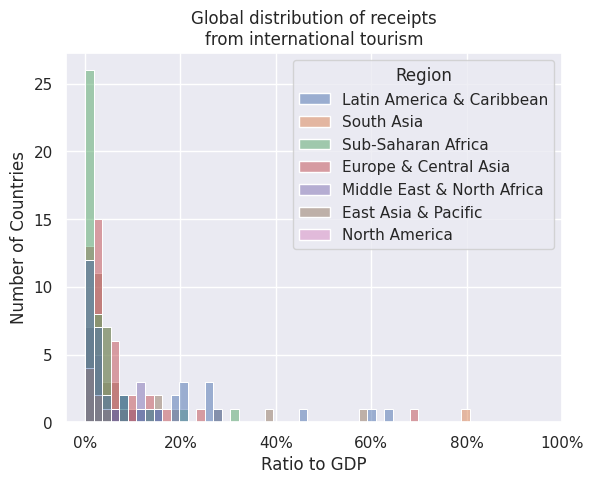

In [ ]:
rpgdp_hist = sns.histplot(data=df_country_avgs, x=rgdp, hue='region')
rpgdp_hist.set(title='Global distribution of receipts\nfrom international tourism', xlabel='Ratio to GDP', ylabel='Number of Countries')
rpgdp_hist.legend_.set_title('Region')
x_ticks = [0, 0.20, 0.40, 0.60, 0.80, 1.0]
rpgdp_hist.set_xticks(x_ticks)
rpgdp_hist.set_xticklabels(['{:.0%}'.format(x) for x in x_ticks])
plt.show()

It appears that the ratio of international tourism receipts to GDP is less than 15% for most countries, but there appear to be some significant teable outliers. 

Because the histogram is so positively skewed, it's hard to gauge it accurately on appearance alone. Let's start by finding some measures of central tendency so that we can better classify each country by its economic dependence on tourism.

In [ ]:
dependence_centers = {}
dc = dependence_centers

dc['mean'] = df_country_avgs[rgdp].mean()
dc['median'] = df_country_avgs[rgdp].median()
dc['std'] = df_country_avgs[rgdp].std()
dc['quarts'] = df_country_avgs[rgdp].quantile([0.25, 0.75], interpolation='nearest')

print(f'Mean: {dc['mean']:.2%}')
print(f'Median: {dc['median']:.2%}')
print(f'Standard Deviation: {dc['std']:.2%}')
print(f'Q1: {dc['quarts'][0.25]:.2%}\nQ3: {dc['quarts'][0.75]:.2%}')

Mean: 6.96%
Median: 2.75%
Standard Deviation: 11.99%
Q1: 1.36%
Q3: 6.63%


Now that we have those out of the way, we can begin classifying the countries into the degree of their economic dependency on tourism using the following four categories:

-Mainly Dependent

-Moderately Dependent

-Partly Dependent

-Independent

 Let's classify the countries that are mainly to wholly economically dependent on tourism. We'll classify anything more than one standard deviation away from the median as "Mainly Dependent."

In [ ]:
one_sigma = dc['median'] + dc['std']
mainly_dependent_countries = df_country_avgs[['country',rgdp]].loc[df_country_avgs[rgdp] >= one_sigma].sort_values(by=rgdp, ascending=False)
mainly_dependent_countries.reset_index(drop=True, inplace=True)
mainly_dependent_countries.style.format({rgdp: '{:.2%}'})

It appears that all of the countries that have a higher dependance on tourism are small.  Almost all of them are also island nations, with the only exceptions being Andorra, Macau, Montenegro and Croatia. Let's confirm that by grouping it by region.

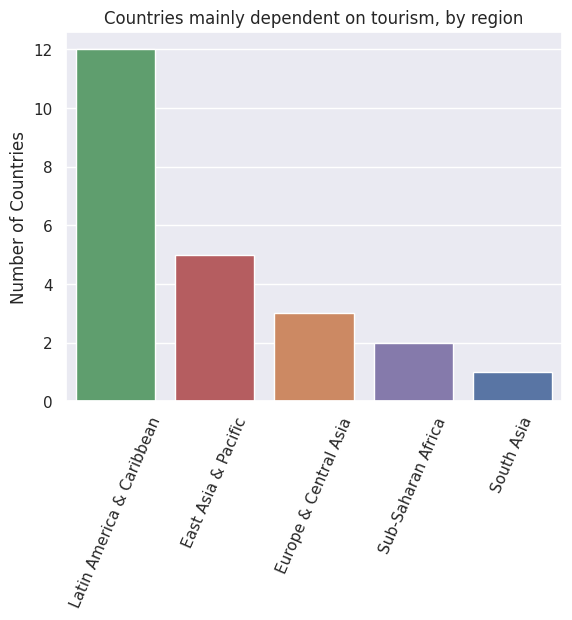

In [ ]:
mainly_dependent_regions = mainly_dependent_countries.merge(right=df_country_avgs[['country', 'region']], on='country').reset_index(drop=True)

regional_mainly = sns.countplot(data=mainly_dependent_regions, x='region', hue='region', order=mainly_dependent_regions.value_counts('region').index)

for tick in regional_mainly.get_xticklabels():
    tick.set_rotation(66.67)

regional_mainly = regional_mainly.set(title='Countries mainly dependent on tourism, by region', xlabel='', ylabel='Number of Countries')
plt.show()

This appears to match up with our observation, with most of the countries being either in the Caribbean or in the Pacific.

Let's next take a look at all of the countries on a map. Because of how heavily skewed the data is, we can see a greater difference in the colors of countries that are less dependant on tourism by setting the color scale to the upper bound of one standard deviation, 15.4%.

In [ ]:
fig = go.Figure(data=go.Choropleth(
        locations=df_country_avgs.country_code,
        z=df_country_avgs[rgdp],
        zauto=False,
        zmax=0.154,
        text=df_country_avgs.country,
        colorscale=[
            [0.0, 'rgb(0,24,128)'],
            [0.1774, 'rgb(225,230,230)'],
            [0.1874, 'rgb(230,230,220)'],
            [0.3643, 'rgb(215,80,60)'],
            [1.0, 'rgb(128,24,0)']
        ],
        autocolorscale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar=dict(
            tickformat='.0%'
        ),
        )
        )

fig.update_layout(
    width=1024,
    height=512,
    title='Ratio between international<br>tourism receipts and average GDP<br>(1995-2020)',
    geo={
        'showcoastlines': False,
        'projection_type': 'natural earth'
    } 
)
fig.show()

It appears that, on the whole, most countries have a very low dependance on tourism; however, there are still some countries that are visibly more dependant on it than others.

Let's see which ones those may be, starting with those that are moderatley dependent on tourism, which we will define as the lower bound of the upper quartile to the upper bound of one standard deviation, which would be 6.70% to 15.4%.

In [ ]:
moderately_dependent_countries = df_country_avgs[['country',rgdp]].loc[(df_country_avgs[rgdp] >= dc['quarts'][0.75]) & (df_country_avgs[rgdp] < one_sigma)].sort_values(by=rgdp, ascending=False)
moderately_dependent_countries.reset_index(drop=True, inplace=True)
moderately_dependent_countries.style.format({rgdp: '{:.2%}'})

There are roughly the same amount, but these countries are much more diverse. As a result, the list alone is a bit more difficult to conceptualize at a glance, so let's split this up by region.

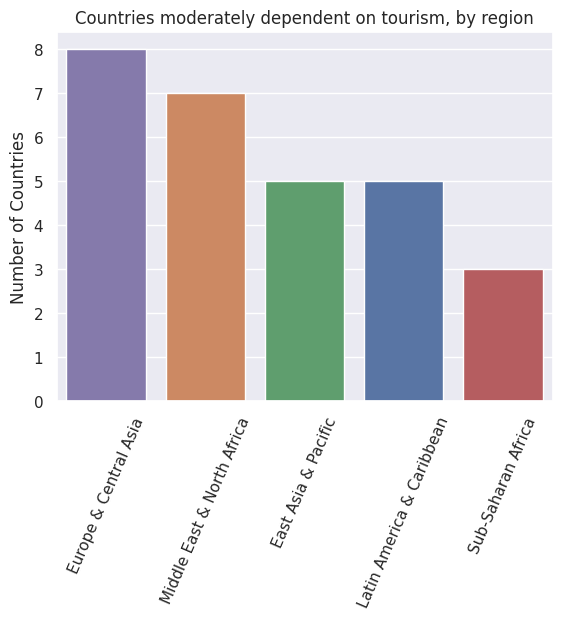

In [ ]:
moderately_dependent_regions = moderately_dependent_countries.merge(right=df_country_avgs[['country', 'region']], on='country').reset_index(drop=True)

regional_moderately = sns.countplot(data=moderately_dependent_regions, x='region', hue='region', order=moderately_dependent_regions.value_counts('region').index)

for tick in regional_moderately.get_xticklabels():
    tick.set_rotation(66.67)

regional_moderately = regional_moderately.set(title='Countries moderately dependent on tourism, by region', xlabel='', ylabel='Number of Countries')
plt.show()

It looks like most of the countries with economies that are partly dependant on tourism are predominantly located in the Europe & Central Asia, the Middle East & North Africa, and East Asia & Pacific regions.

Let's continue our classification with countries that are partly dependent on tourism.

In [ ]:
partly_dependent_countries = df_country_avgs[['country', rgdp]].loc[(df_country_avgs[rgdp] > dc['median']) & (df_country_avgs[rgdp] < dc['quarts'][0.75])].sort_values(by=rgdp, ascending=False)
partly_dependent_countries.reset_index(drop=True, inplace=True)
partly_dependent_countries.style.format({rgdp: '{:.2%}'})

There are considerably more countries in this category--almost as much as the other two combined! This really needs to be broken up regionally to see any kind of trend.

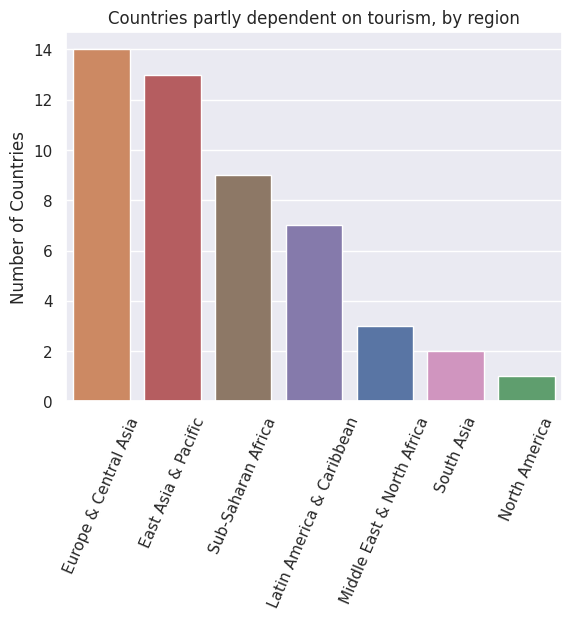

In [ ]:
partly_dependent_regions = partly_dependent_countries.merge(right=df_country_avgs[['country', 'region']], on='country').reset_index(drop=True)

regional_partly = sns.countplot(data=partly_dependent_regions, x='region', hue='region', order=partly_dependent_regions.value_counts('region').index)

for tick in regional_partly.get_xticklabels():
    tick.set_rotation(66.67)

regional_partly = regional_partly.set(title='Countries partly dependent on tourism, by region', xlabel='', ylabel='Number of Countries')
plt.show()

This is definitely the most diverse group so far. The dominant regions are Europe & Central Asia, East Asia & Pacific, and Sub-Saharan Africa.

Finally, let's see which countries we would classify as economically "independent". 

In [ ]:
independent_countries = df_country_avgs[['country', rgdp]].loc[df_country_avgs[rgdp] <= dc['median']].sort_values(rgdp, ascending=False)
independent_countries.reset_index(drop=True, inplace=True)
independent_countries.style.format({rgdp: '{:.2%}'})

This list, as the math would suggest, contains about half of the world's countries. 

Let's see how it breaks down regionally.

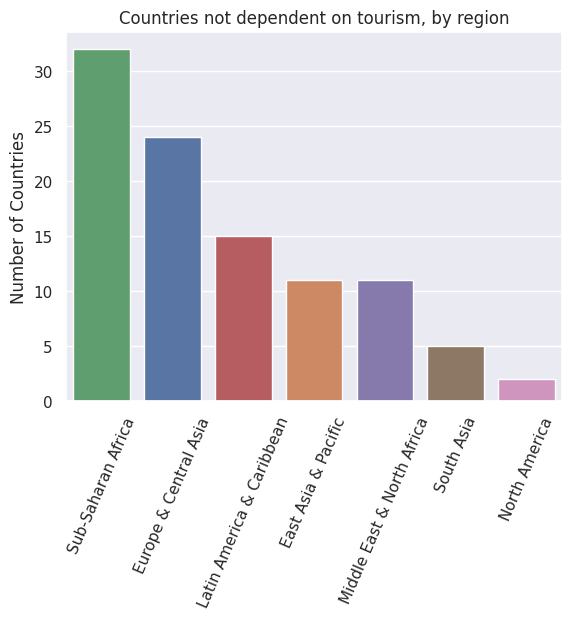

In [ ]:
independent_regions = independent_countries.merge(right=df_country_avgs[['country', 'region']], on='country').reset_index(drop=True)

regional_independent = sns.countplot(data=independent_regions, x='region', hue='region', order=independent_regions.value_counts('region').index)

for tick in regional_independent.get_xticklabels():
    tick.set_rotation(66.67)

regional_independent = regional_independent.set(title='Countries not dependent on tourism, by region', xlabel='', ylabel='Number of Countries')
plt.show()

This is the most diverse set of regions, with every possible region having countries that are not economically dependent on tourism.

### Is there a correlation between a country's number of international arrivals and economic dependency on tourism?

Let's make a scatterplot to see if there is a correlation here.

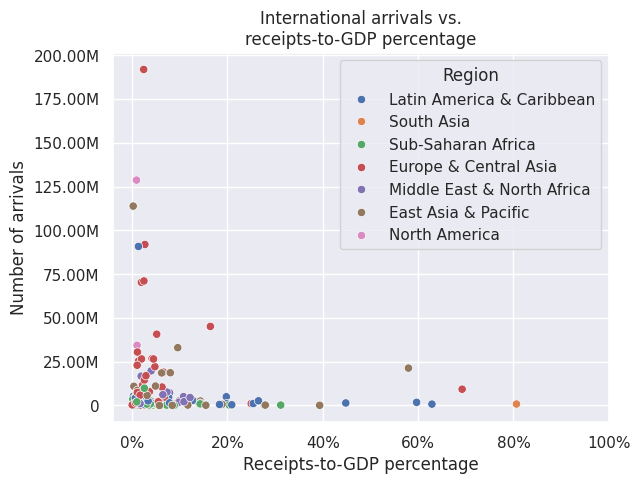

In [ ]:
arrivals_vs_dependence = sns.scatterplot(data=df_country_avgs, x=rgdp, y='avg_arrivals', hue='region')
arrivals_vs_dependence.set(
    title='International arrivals vs.\nreceipts-to-GDP percentage', 
    xlabel='Receipts-to-GDP percentage', 
    ylabel='Number of arrivals')
arrivals_vs_dependence.legend_.set_title('Region')
x_ticks = [0, 0.20, 0.40, 0.60, 0.80, 1.0]
arrivals_vs_dependence.set_xticks(x_ticks)
arrivals_vs_dependence.set_xticklabels(['{:.0%}'.format(x) for x in x_ticks])

y_ticks = [x for x in np.arange(0, 2.25*10**8, 2.5*10**7)]
arrivals_vs_dependence.set_yticks(y_ticks)
arrivals_vs_dependence.set_yticklabels(formatter(y, False) for y in y_ticks)

plt.show()

It does not appear that there is any correlation here. This likely means the economies of the countries most dependent on tourism are likely smaller, since they receive significantly less international arrivals than countries that are not economically dependent on tourism.

### Is there a correlation between individual income and the number of departures abroad?

Let's take a look and see if individual income has any influence on a country's citizens travelling abroad.

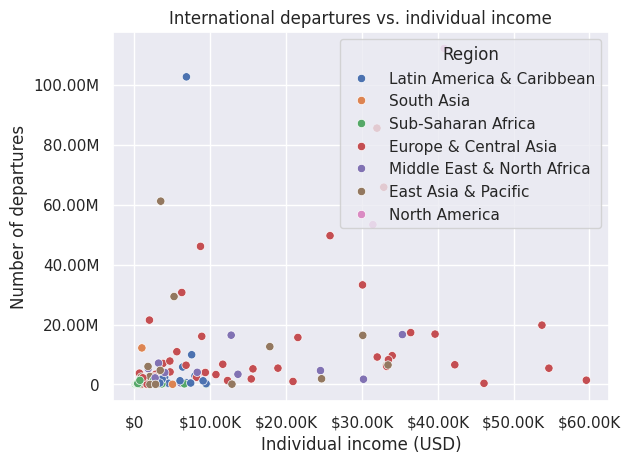

In [ ]:
income_vs_departures = sns.scatterplot(data=df_country_avgs, x='avg_income', y='avg_departures', hue='region')
income_vs_departures.set(
    title='International departures vs. individual income', 
    xlabel='Individual income (USD)', 
    ylabel='Number of departures')
income_vs_departures.legend_.set_title('Region')

x_ticks = [x for x in range(0, 70000, 10000)]
income_vs_departures.set_xticks(x_ticks)
income_vs_departures.set_xticklabels([formatter(x, True) for x in x_ticks])

y_ticks = [x for x in np.arange(0, 1.2*10**8, 2*10**7)]
income_vs_departures.set_yticks(y_ticks)
income_vs_departures.set_yticklabels(formatter(y, False) for y in y_ticks)

plt.show()

Though not very defined, there does appear to be somewhat of a weak correlation between higher individual incomes and a greater number of trips abroad.